In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

## 인구 감소 심화 지역 확인
### 초등학교 지역별 학생수 감소율

In [3]:
element_student_region = pd.read_csv("data/(공공데이터) 초등학교_1965-2024_03_시도별 학생수.csv", encoding = 'cp949')
element_student_region = element_student_region.drop(columns = ['계'])

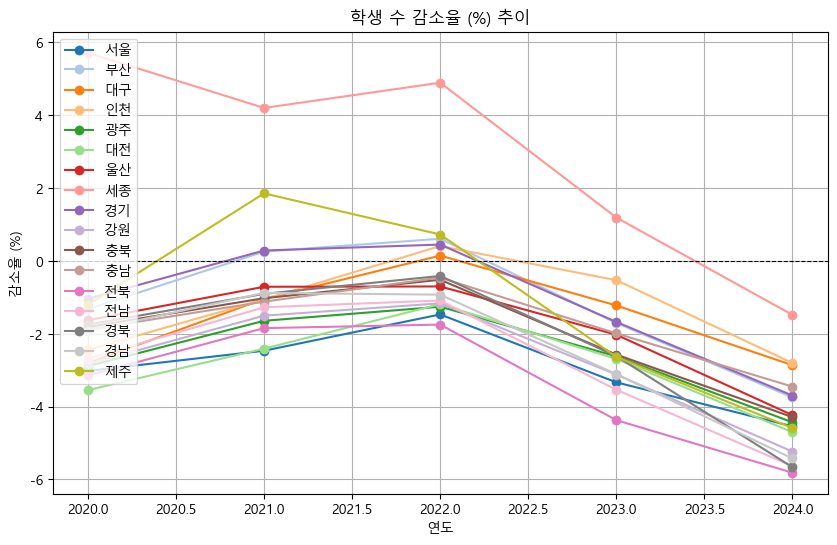

In [4]:
student_10year = element_student_region[element_student_region['연도'] >= 2019]

# 감소율 (%) 계산
df_pct_change = student_10year.set_index("연도").pct_change() * 100

# tab20 팔레트 사용 (17개 색상)
colors = plt.cm.tab20.colors

# 그래프 그리기
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_pct_change.columns):
    plt.plot(df_pct_change.index, df_pct_change[col], marker="o", label=col, color=colors[i])

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # 0% 감소율 기준선
plt.title("학생 수 감소율 (%) 추이")
plt.xlabel("연도")
plt.ylabel("감소율 (%)")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()



### 초등학교 지역별 학생수 누적감소율

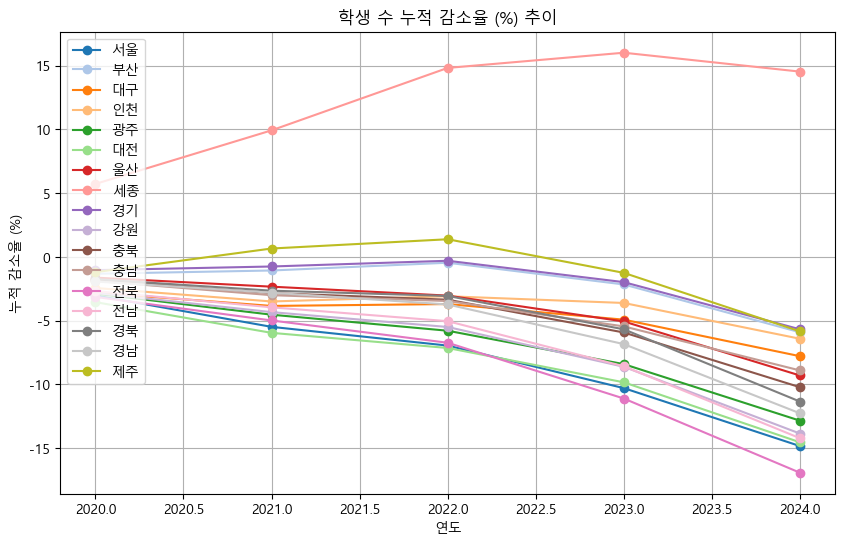

In [5]:
import matplotlib.pyplot as plt

# 누적 감소율 계산
df_cumulative_pct_change = df_pct_change.cumsum()  # 누적 합산

# tab20 색상 팔레트 사용 (17개 색상)
colors = plt.cm.tab20.colors

# 그래프 그리기
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_cumulative_pct_change.columns):
    plt.plot(df_cumulative_pct_change.index, df_cumulative_pct_change[col], marker="o", label=col, color=colors[i])

plt.title("학생 수 누적 감소율 (%) 추이")
plt.xlabel("연도")
plt.ylabel("누적 감소율 (%)")
plt.legend(loc='upper left')  # 범례를 왼쪽 상단으로 위치 조정
plt.grid(True)
plt.show()


- 감소율이 높은 지역은 학생 수가 빠르게 줄어드는 지역으로, 인구 감소가 급격히 일어나고 있다.
- 누적 감소율이 높은 지역은 앞으로의 학생 수 감소가 더욱 두드러질 가능성이 크므로, 조기 대응이 필요한 지역으로 고려할 수 있다.

- 전북이 학교 병합과 교직원 해고 문제 해결을 위한 긴급한 조치가 필요하다 판단

---

## 기초 데이터 분석

### 전북 초등학교 정보

In [6]:
school_data = pd.read_csv("data/학교기본정보(초)_전북특별자치도교육청.csv")
school_data = school_data[['학교명','설립구분','주소내역','위도','경도', '폐교여부', '폐교일자', '휴교여부']]

In [7]:
open_school = school_data[(school_data['폐교여부'] == 'N') & (school_data['휴교여부'] == 'N')]
open_school = open_school.drop(columns=['폐교여부','폐교일자','휴교여부'])

### 폐교학교 정보

In [8]:
close_school = school_data[(school_data['폐교여부'] != 'N') | (school_data['휴교여부'] != 'N')]
close_school = close_school.drop(columns=['폐교여부','폐교일자','휴교여부'])

---

# 파생변수 설정
## 학교 관련 변수
### 학생 수 데이터 

In [9]:
# 결과를 저장할 리스트
all_data = []

# 2014년부터 2024년까지 반복
for year in range(2008, 2025):
    # 파일명 생성 (연도에 맞게 파일명 변경)
    filename = f"data/2008~2024 학생수/{year}년도_학년별·학급별 학생수(초)_전북특별자치도교육청.csv"

    # CSV 파일 읽기
    df = pd.read_csv(filename)

    # 연도 추가
    df['연도'] = year

    # 학년별 학생 수를 리스트 형태로 변환
    df['학년별 학생수'] = df[[f'{i}학년 학생수' for i in range(1, 7)]].apply(lambda row: list(row), axis=1)

    # 기존 개별 학년 학생 수 컬럼 삭제
    df = df.drop(columns=[f'{i}학년 학생수' for i in range(1, 7)])

    df = df[['지역','학교명', '연도', '설립구분', '학년별 학생수', '학생수(계)', '학급수(계)', '교사수']]

    # 컬럼명 변경
    df.columns = ['지역','학교명', '연도', '설립구분', '학년별 학생수', '학생수', '학급수', '교원수']

    df['지역'] = df['지역'].str.replace('전북특별자치도 ', '', regex=False)
    
    # 리스트에 추가
    all_data.append(df)
    

# 모든 연도 데이터를 하나의 데이터프레임으로 병합
merged_element_data = pd.concat(all_data, ignore_index=True)

# 학교 기본 정보(open_school)와 병합
merged_open_data = pd.merge(open_school, merged_element_data, how='left', on='학교명', suffixes=('', '_other'))

# 불필요한 "_other" 컬럼 제거
merged_open_data = merged_open_data.filter(regex='^(?!.*_other)')

# 연도 오름차순 정렬
merged_open_data = merged_open_data.sort_values(by=['학교명','연도'], ascending=[True, True]).reset_index(drop=True)

merged_open_data = merged_open_data[['학교명','지역', '연도', '설립구분','주소내역','위도','경도', '학년별 학생수', '학생수', '학급수', '교원수']]

merged_open_data["지역"] = merged_open_data["지역"].apply(lambda x: "전주시" if "전주시" in str(x) else x)


###  전입전출 데이터

In [10]:
# 결과를 저장할 리스트
all_inout_data = []

# 2014년부터 2024년까지 반복
for year in range(2008, 2025):
    # 파일명 생성 (연도에 맞게 파일명 변경)
    filename = f"data/2008~2024 전입전출/{year}년도_전·출입 및 학업중단 학생 수(초)_전북특별자치도교육청.csv"

    # CSV 파일 읽기
    df = pd.read_csv(filename)

    # 필요한 열 선택 및 이름 변경
    df = df[['학교명', '전입학생수(계)', '전출학생수(계)']]
    df.columns = ['학교명', '전입', '전출']

    # 연도 추가
    df['연도'] = year

    # 리스트에 추가
    all_inout_data.append(df)

# 모든 연도 데이터를 하나의 데이터프레임으로 병합
merged_inout_data = pd.concat(all_inout_data, ignore_index=True)

# merged_element_data와 병합 (기존 merged_element_data_2024와 동일한 방식)
merged_open_data = pd.merge(merged_open_data, merged_inout_data, how='left', on=['학교명', '연도'], suffixes=('', '_other'))

# 불필요한 "_other" 컬럼 제거
merged_open_data = merged_open_data.filter(regex='^(?!.*_other)')

# '전입'과 '전출' 열의 NaN 값을 0으로 채운 후 정수형(int)으로 변환
merged_open_data['전입'] = pd.to_numeric(merged_open_data['전입'], errors='coerce').fillna(0).astype(int)
merged_open_data['전출'] = pd.to_numeric(merged_open_data['전출'], errors='coerce').fillna(0).astype(int)

### 학교 재정 관련 데이터
- 예산 수입

In [11]:
# 결과를 저장할 리스트
all_money_in_data = []

# 2014년부터 2024년까지 반복
for year in range(2008, 2025):
    # 파일명 생성 (연도에 맞게 파일명 변경)
    filename = f"data/2008~2024 예산세입/{year}년도_학교회계 예·결산서(국공립)(예산세입)(초)_전북특별자치도교육청.csv"

    # CSV 파일 읽기
    df = pd.read_csv(filename)

    # 필요한 열 선택 및 이름 변경
    df = df[['학교명', '학부모부담수입']]

    # 연도 추가
    df['연도'] = year

    # 리스트에 추가
    all_money_in_data.append(df)

# 모든 연도 데이터를 하나의 데이터프레임으로 병합
merged_money_in_data = pd.concat(all_money_in_data, ignore_index=True)

# merged_element_data와 병합
merged_open_data = pd.merge(merged_open_data, merged_money_in_data, how='left', on=['학교명', '연도'], suffixes=('', '_other'))

# 불필요한 "_other" 컬럼 제거
merged_open_data = merged_open_data.filter(regex='^(?!.*_other)')

- 예산 수출

In [12]:
# 결과를 저장할 리스트
all_money_out_data = []

# 2014년부터 2024년까지 반복
for year in range(2008, 2025):
    # 파일명 생성 (연도에 맞게 파일명 변경)
    filename = f"data/2008~2024 예산세출/{year}년도_학교회계 예·결산서(국공립)(예산세출)(초)_전북특별자치도교육청.csv"

    # CSV 파일 읽기
    df = pd.read_csv(filename)

    # 필요한 열 선택 및 이름 변경
    df = df[['학교명','학교일반운영']]

    # 연도 추가
    df['연도'] = year

    # 리스트에 추가
    all_money_out_data.append(df)

# 모든 연도 데이터를 하나의 데이터프레임으로 병합
merged_money_out_data = pd.concat(all_money_out_data, ignore_index=True)

# merged_element_data와 병합
merged_open_data = pd.merge(merged_open_data, merged_money_out_data, how='left', on=['학교명', '연도'], suffixes=('', '_other'))

# 불필요한 "_other" 컬럼 제거
merged_open_data = merged_open_data.filter(regex='^(?!.*_other)')

## 지역 관련 변수
### 생활 편의성
- 학교 인근 상가

In [13]:
import pandas as pd
import numpy as np

# 상가 데이터 읽기 (파일 인코딩과 결측치 처리)
stores = pd.read_csv("data/소상공인시장진흥공단_상가(상권)정보_전북_202412.csv", encoding="utf-8")
stores.dropna(axis=1, inplace=True)

# 거리 계산을 위한 Haversine 함수 정의
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 지구 반지름 (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# 거리 임계값 (500미터, 0.5km)
distance_threshold = 0.5  # km

# 각 학교에 대해 인근 상가 수 계산
school_store_counts = []

for _, school in merged_open_data.iterrows():
    # 학교 좌표
    school_lat, school_lon = school['위도'], school['경도']
    
    # Haversine 공식을 사용해 모든 상가와의 거리 계산
    distances = haversine(school_lat, school_lon, stores['위도'].values, stores['경도'].values)
    
    # 500m 이내에 있는 상가 수 계산
    store_count = np.sum(distances < distance_threshold)
    
    # 결과 저장 (예: 학교명과 상가 수)
    school_store_counts.append({
        'school_name': school['학교명'],
        'store_count': store_count
    })

# 결과 데이터프레임으로 변환
school_store_counts_df = pd.DataFrame(school_store_counts)

# 중복 제거
school_store_counts_df = school_store_counts_df.drop_duplicates()

merged_open_data = pd.merge(merged_open_data, school_store_counts_df, how = 'left', left_on="학교명", right_on='school_name')

C:\Users\user\AppData\Local\Temp\ipykernel_26664\1076256483.py:5: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  stores = pd.read_csv("data/소상공인시장진흥공단_상가(상권)정보_전북_202412.csv", encoding="utf-8")


- 인근 버스정류장

In [14]:
# 버스 정류장 데이터 읽기 (파일 인코딩과 결측치 처리)
buses = pd.read_csv("data/국토교통부_전국 버스정류장 위치정보_20241028.csv", encoding="cp949")

# 각 학교에 대해 인근 버스 정류장 수 계산
school_bus_counts = []

for _, school in merged_open_data.iterrows():
    # 학교 좌표
    school_lat, school_lon = school['위도'], school['경도']
    
    # Haversine 함수를 사용해 모든 버스 정류장과의 거리 계산
    distances = haversine(school_lat, school_lon, buses['위도'].values, buses['경도'].values)
    
    # 500m 이내에 있는 버스 정류장 수 계산
    bus_count = np.sum(distances < distance_threshold)
    
    # 결과 저장 (예: 학교명과 버스 정류장 수)
    school_bus_counts.append({
        '학교명': school['학교명'],
        'bus_count': bus_count
    })

# 결과 데이터프레임으로 변환
school_bus_counts_df = pd.DataFrame(school_bus_counts)

# 중복 제거
school_bus_counts_df = school_bus_counts_df.drop_duplicates()

# 기존 merged_open_data와 학교명 기준으로 병합
merged_open_data = pd.merge(merged_open_data, school_bus_counts_df, how='left', on="학교명")


In [15]:
merged_open_data = merged_open_data.drop(columns=['school_name'])

### 학원 관련 정보

In [ ]:
import requests
import pandas as pd
import time

# 📌 Kakao API Key (REST API 키 입력)
KAKAO_API_KEY = "68c5344de77cf5317c75a668a8ac54fd"

# 📌 데이터 불러오기 (4860개 데이터, 도로명 주소 컬럼 이름 확인)
df = pd.read_csv("data/academy_data.csv")  # 예제: CSV 파일
# df.head()  # 컬럼 확인

# 📌 결과 저장 리스트
latitudes = []
longitudes = []

# 📌 주소 변환 함수
def get_lat_lon(address):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)
    data = response.json()

    if "documents" in data and len(data["documents"]) > 0:
        lat = data["documents"][0]["y"]
        lon = data["documents"][0]["x"]
        return lat, lon
    else:
        return None, None

# 📌 주소 변환 실행 (반복문)
for idx, row in df.iterrows():
    address = row["도로명주소"]  # 컬럼명 확인 후 수정 필요
    lat, lon = get_lat_lon(address)

    latitudes.append(lat)
    longitudes.append(lon)

    print(f"{idx+1}/{len(df)} 변환 완료: {address} → {lat}, {lon}")

    time.sleep(0.1)  # 📌 속도 제한 방지 (0.1초 대기)

# 📌 결과 DataFrame 추가
df["위도"] = latitudes
df["경도"] = longitudes

# 📌 변환된 데이터 저장
df.to_csv("academy_with_latlon.csv", index=False, encoding="utf-8-sig")

print("📍 모든 주소 변환 완료! 파일 저장됨.")


In [31]:
import numpy as np
from sklearn.neighbors import KernelDensity

academy_latlon = pd.read_csv("academy_with_latlon.csv")
academy_latlon = academy_latlon[['학원명','위도','경도']]

# 결측값 제거 (위도, 경도)
academy_df_clean = academy_latlon.dropna(subset=["위도", "경도"])

# 학원의 위도, 경도 데이터 추출
academy_coords = academy_df_clean[['위도', '경도']].values

# KDE 모델 설정
bandwidth = 0.01  # 반경 설정 (값이 크면 넓은 범위에서 밀집도 계산)
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(academy_coords)

# 학원별 KDE 값 계산
academy_kde_scores = kde.score_samples(academy_coords)
academy_df_clean["academy_hotspot_value"] = np.exp(academy_kde_scores)  # 로그 확률을 확률로 변환


C:\Users\user\AppData\Local\Temp\ipykernel_26664\628276816.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  academy_df_clean["academy_hotspot_value"] = np.exp(academy_kde_scores)  # 로그 확률을 확률로 변환


In [32]:
academy_df_clean

,학원명,위도,경도,academy_hotspot_value
0,굿키즈 영어교습소,35.435795,126.706737,19.562348
1,기쁨피아노교습소,35.435989,126.704946,20.168800
2,김공수영어교습소,35.435448,126.701482,20.023619
3,김유식수학교습소,35.435263,126.706198,19.796524
4,날개달린그림미술교습소,35.435263,126.706198,19.796524
...,...,...,...,...
4855,소리엘음악학원,35.790421,127.424400,4.685384
4856,쇼팽과아이들음악학원,35.790042,127.423972,4.663077
4857,신선생 수학전문학원,35.792198,127.426193,4.610492
4858,진안 e해법수학학원,35.790085,127.423570,4.640587


In [ ]:
from scipy.spatial import KDTree

# 학원 KDTree 생성 (위경도 기준)
academy_tree = KDTree(academy_df_clean[["위도", "경도"]].values)

# 학교별 반경 1000m 내 학원 밀집도 평균 계산
radius = 0.01  # 위도/경도로 변환한 약 500m 반경
school_density_values = []

for _, school in merged_open_data.iterrows():
    school_location = [school["위도"], school["경도"]]
    # 반경 1000m 내 학원 인덱스 찾기
    nearby_indices = academy_tree.query_ball_point(school_location, r=radius)
    # 해당 학원들의 KDE 값 평균 계산
    if nearby_indices:
        density_mean = academy_df_clean.iloc[nearby_indices]["academy_hotspot_value"].mean()
    else:
        density_mean = 0  # 반경 내 학원이 없으면 0 처리

    school_density_values.append(density_mean)

# 학교 데이터프레임에 학원 밀집도 변수 추가
merged_open_data["school_academy_density"] = school_density_values

### 어린이집 유치원

In [115]:
nursery = pd.read_excel('data/어린이집기본정보조회(정기)-기준일(20240131).xls', engine="xlrd") 
nursery = nursery[['어린이집명','위도','경도']]
nursery = nursery.dropna()

In [116]:
nursery

,어린이집명,위도,경도
1,도도어린이집,35.793075,127.140940
2,퍼스트어린이집,35.832803,127.113146
3,새소망어린이집,35.869312,127.124500
4,아이원어린이집,35.831296,127.096206
5,서신피노키오어린이집,35.836279,127.117782
...,...,...,...
1994,함께하는어린이집,35.705632,126.788145
1995,참프레어린이집,35.735568,126.722720
1997,피터팬어린이집,35.722359,126.735531
1998,큰별 어린이집,35.760256,126.697974


In [50]:
merged_open_data.to_csv("merged_open_data.csv", index = False)

## 폐교 초등학교
### 학생 수 데이터

In [51]:
merged_close_data = pd.merge(close_school, merged_element_data, how = 'left', on = '학교명', suffixes=('', '_other'))
merged_close_data = merged_close_data.filter(regex='^(?!.*_other)')
merged_close_data = merged_close_data.dropna()
merged_close_data = merged_close_data.sort_values(by=['학교명', '연도'], ascending=[True, True]).reset_index(drop=True)
merged_close_data = merged_close_data[['학교명','지역', '연도', '설립구분','주소내역','위도','경도', '학년별 학생수', '학생수', '학급수', '교원수']]

In [52]:
# 연도, 학생수, 학급수, 교원수 열을 int로 변환
merged_close_data['연도'] = merged_close_data['연도'].astype(int)
merged_close_data['학생수'] = pd.to_numeric(merged_close_data['학생수'], errors='coerce').fillna(0).astype(int)
merged_close_data['학급수'] = pd.to_numeric(merged_close_data['학급수'], errors='coerce').fillna(0).astype(int)
merged_close_data['교원수'] = pd.to_numeric(merged_close_data['교원수'], errors='coerce').fillna(0).astype(int)

### 전입전출 데이터

In [53]:
# merged_element_data와 병합 (기존 merged_element_data_2024와 동일한 방식)
merged_close_data = pd.merge(merged_close_data, merged_inout_data, how='left', on=['학교명', '연도'], suffixes=('', '_other'))

# 불필요한 "_other" 컬럼 제거
merged_close_data = merged_close_data.filter(regex='^(?!.*_other)')

merged_close_data = merged_close_data.sort_values(by=['학교명','연도'], ascending=[True, True]).reset_index(drop=True)

# '전입'과 '전출' 열의 NaN 값을 0으로 채운 후 정수형(int)으로 변환
merged_close_data['전입'] = pd.to_numeric(merged_close_data['전입'], errors='coerce').fillna(0).astype(int)
merged_close_data['전출'] = pd.to_numeric(merged_close_data['전출'], errors='coerce').fillna(0).astype(int)


# 파생변수 예측

### 전입, 전출, 학부모부담수입, 학교일반운영

In [40]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 불필요한 경고 제거
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('merged_open_data.csv')

# 열 이름 정리 및 공백 제거
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns={'학교명': 'School', '연도': 'Year', '전입': 'Transfer_In', '전출': 'Transfer_Out',
                            '학부모부담수입': 'Parent_Income', '학교일반운영': 'School_Operation'})
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.sort_values(by=['School', 'Year'])

# 2008~2024년 실제 데이터만 선택
data = data[(data['Year'].dt.year >= 2008) & (data['Year'].dt.year <= 2024)]
data['Type'] = 'Actual'  # 실제 데이터 구분

# 예측할 변수 리스트
target_columns = ['Transfer_In', 'Transfer_Out', 'Parent_Income', 'School_Operation']

# 2. 학교별 SARIMA 모델 학습 및 2025~2029년 예측
schools = data['School'].unique()
forecast_results = []

for school in schools:
    school_data = data[data['School'] == school].copy()
    school_data = school_data.set_index('Year')

    for col in target_columns:
        ts = school_data[col]

        # 데이터 포인트가 부족하면 2025~2029년 모두 NaN 처리
        if len(ts) < 3:
            forecast_values = [np.nan] * 5
        else:
            try:
                # 다양한 (p,d,q) 조합 테스트 (Grid Search)
                best_aic = float("inf")
                best_order = None
                for p in range(0, 3):  # p 값 범위
                    for d in range(0, 2):  # d 값 범위
                        for q in range(0, 3):  # q 값 범위
                            try:
                                temp_model = SARIMAX(ts, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                                     enforce_stationarity=False, enforce_invertibility=False)
                                temp_result = temp_model.fit(disp=False)
                                if temp_result.aic < best_aic:
                                    best_aic = temp_result.aic
                                    best_order = (p, d, q)
                            except:
                                continue

                # 최적의 (p,d,q)로 SARIMA 모델 학습
                model = SARIMAX(ts, order=best_order, seasonal_order=(0,0,0,0),
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)

                # 5단계 예측 (2025~2029)
                forecast_values = model_fit.forecast(steps=5).tolist()

                # 동일한 값이 반복될 경우 약간의 랜덤 잡음 추가
                if len(set(forecast_values)) == 1:
                    forecast_values = [val + np.random.randint(-2, 3) for val in forecast_values]
                
            except Exception as e:
                # 모델 학습 실패 시 NaN 처리
                forecast_values = [np.nan] * 5

        # 예측 결과 저장
        for i, pred in enumerate(forecast_values):
            forecast_year = 2025 + i
            forecast_results.append({
                'School': school,
                'Year': pd.to_datetime(str(forecast_year), format='%Y'),
                'Variable': col,
                'Value': max(0, int(round(pred)))  # 음수 값은 0으로 변환 후 정수 변환
            })

# 예측 결과 데이터프레임 생성
forecast_df = pd.DataFrame(forecast_results)

# 피벗: 학교별로 연도를 열로 변환
pivot_forecast_df = forecast_df.pivot(index=["School", "Variable"], columns="Year", values="Value").reset_index()

# 4. 결과 저장
pivot_forecast_df.to_csv('forecast_sarima_2025_2029.csv', index=False)

print("예측 완료. 결과 파일: forecast_sarima_2025_2029.csv")


예측 완료. 결과 파일: forecast_sarima_2025_2029.csv


In [47]:
pivot_forecast_df = pd.read_csv("forecast_sarima_2025_2029.csv")

In [48]:
pivot_forecast_df

,School,Variable,2025-01-01 00:00:00,2026-01-01 00:00:00,2027-01-01 00:00:00,2028-01-01 00:00:00,2029-01-01 00:00:00
0,가천초등학교,Parent_Income,15166993,15511338,15564688,15485248,15517289
1,가천초등학교,School_Operation,79409633,79169721,79200610,79170600,79175388
2,가천초등학교,Transfer_In,2,3,3,3,3
3,가천초등학교,Transfer_Out,3,3,3,3,3
4,가평초등학교,Parent_Income,14287579,11547422,15892487,11794827,14700173
...,...,...,...,...,...,...,...
1631,흥덕초등학교,Transfer_Out,4,6,6,6,6
1632,흥왕초등학교,Parent_Income,14972354,14885185,14885185,14885185,14885185
1633,흥왕초등학교,School_Operation,72881213,71464693,73832726,72004644,72814529
1634,흥왕초등학교,Transfer_In,1,1,1,1,1


In [69]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 불필요한 경고 제거
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('merged_open_data.csv')

# 열 이름 정리 및 공백 제거, 변수명 영어로 변경
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns={'학교명': 'School', '연도': 'Year', '전입': 'Transfer_In', 
                            '전출': 'Transfer_Out', '학부모부담수입': 'Parent_Income', 
                            '학교일반운영': 'School_Operation'})
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.sort_values(by=['School', 'Year'])

# 2008~2024년 실제 데이터만 선택
data = data[(data['Year'].dt.year >= 2008) & (data['Year'].dt.year <= 2024)]
data['Type'] = 'Actual'  # 실제 데이터 구분

# 예측할 변수 리스트
target_columns = ['Transfer_In', 'Transfer_Out', 'Parent_Income', 'School_Operation']

# 2. 학교별 SARIMA 모델 학습 및 2025~2029년 예측
schools = data['School'].unique()
forecast_results = []

for school in schools:
    school_data = data[data['School'] == school].copy()
    school_data = school_data.set_index('Year')

    for col in target_columns:
        ts = school_data[col]

        # 데이터 포인트가 부족하면 2025~2029년 모두 NaN 처리
        if len(ts) < 3:
            forecast_values = [np.nan] * 5
        else:
            try:
                # 다양한 (p,d,q) 조합 테스트 (Grid Search)
                best_aic = float("inf")
                best_order = None
                for p in range(0, 3):  # p 값 범위
                    for d in range(0, 2):  # d 값 범위
                        for q in range(0, 3):  # q 값 범위
                            try:
                                temp_model = SARIMAX(ts, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                                     enforce_stationarity=False, enforce_invertibility=False)
                                temp_result = temp_model.fit(disp=False)
                                if temp_result.aic < best_aic:
                                    best_aic = temp_result.aic
                                    best_order = (p, d, q)
                            except:
                                continue

                # 최적의 (p,d,q)로 SARIMA 모델 학습
                model = SARIMAX(ts, order=best_order, seasonal_order=(0,0,0,0),
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)

                # 5단계 예측 (2025~2029)
                forecast_values = model_fit.forecast(steps=5).tolist()

                # 동일한 값이 반복될 경우 약간의 랜덤 잡음 추가
                if len(set(forecast_values)) == 1:
                    forecast_values = [val + np.random.randint(-2, 3) for val in forecast_values]
                
            except Exception as e:
                # 모델 학습 실패 시 NaN 처리
                forecast_values = [np.nan] * 5

        # 예측 결과 저장 (각 변수별로 long format)
        for i, pred in enumerate(forecast_values):
            forecast_year = 2025 + i
            forecast_results.append({
                'School': school,
                'Year': pd.to_datetime(str(forecast_year), format='%Y'),
                'Variable': col,
                'Value': max(0, int(round(pred)))  # 음수 값은 0으로 변환 후 정수 변환
            })

# 예측 결과 데이터프레임 생성 (long format)
forecast_df = pd.DataFrame(forecast_results)

# 3. 피벗: 각 학교와 연도별로 행으로 변환하여 각 변수별 값을 컬럼으로 배치
# 최종 열: School, Year, Parent_Income, School_Operation, Transfer_In, Transfer_Out
pivot_forecast_df = forecast_df.pivot(index=["School", "Year"], columns="Variable", values="Value").reset_index()

# 원하는 열 순서로 재정렬 (열명이 target_columns와 일치해야 함)
desired_columns = ['School', 'Year', 'Parent_Income', 'School_Operation', 'Transfer_In', 'Transfer_Out']
pivot_forecast_df = pivot_forecast_df[desired_columns]

# 4. 결과 저장
pivot_forecast_df.to_csv('forecast_sarima_2025_2029.csv', index=False)

print("예측 완료. 결과 파일: forecast_sarima_2025_2029.csv")


예측 완료. 결과 파일: forecast_sarima_2025_2029.csv


In [ ]:
pivot_forecast_df

# 학생 수 예측

In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 불필요한 경고 메시지 제거
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('merged_open_data.csv')
# 열 이름 정리 및 공백 제거
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns={'학교명': 'School', '연도': 'Year', '학생수': 'Students'})
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.sort_values(by=['School', 'Year'])

# 2008~2024년 실제 데이터만 선택 (필요 시 필터링)
data = data[(data['Year'].dt.year >= 2008) & (data['Year'].dt.year <= 2024)]
data['Type'] = 'Actual'  # 실제 데이터 구분

# 2. 각 학교별 ARIMA 모델 학습 및 2025~2029년 예측
schools = data['School'].unique()
forecast_results = []

for school in schools:
    # 학교별 데이터 추출 및 시계열 구성
    school_data = data[data['School'] == school].copy()
    school_data = school_data.set_index('Year')
    ts = school_data['Students']
    
    # 데이터 포인트가 충분하지 않으면 2025~2029년 모두 NaN 처리
    if len(ts) < 3:
        for year in range(2025, 2030):
            forecast_results.append({
                'School': school,
                'Year': pd.to_datetime(str(year), format='%Y'),
                'Students': np.nan,
                'Type': 'Forecast'
            })
        continue
    
    try:
        # ARIMA 모델 학습 (order는 예시로 (1,1,1))
        model = ARIMA(ts, order=(1,1,1))
        model_fit = model.fit()
        # 5단계 예측: 2025년부터 2029년까지
        forecast = model_fit.forecast(steps=5)
    except Exception as e:
        # 모델 학습에 실패하면 NaN 처리
        forecast = [np.nan] * 5
    
    # 예측 결과를 연도별로 저장
    for i, pred in enumerate(forecast):
        forecast_year = 2025 + i
        forecast_results.append({
            'School': school,
            'Year': pd.to_datetime(str(forecast_year), format='%Y'),
            'Students': pred,
            'Type': 'Forecast'
        })

forecast_df = pd.DataFrame(forecast_results)

forecast_df['Students'] = forecast_df['Students'].clip(lower=0)

# 3. 실제 데이터와 예측 데이터를 결합
combined_df = pd.concat([data[['School', 'Year', 'Students', 'Type']], forecast_df], ignore_index=True)
combined_df = combined_df.sort_values(['School', 'Year'])
combined_df['Students'] = combined_df['Students'].round(0).astype(int)

# 예측 데이터만 선택 (Type이 Forecast인 데이터)
forecast_only = combined_df[combined_df['Type'] == 'Forecast'].copy()

# Year 컬럼에서 연도만 추출하여 '년 학생수' 형태의 문자열로 변환
forecast_only['Year_str'] = forecast_only['Year'].dt.year.astype(str) + "년 학생수"

# 피벗: 각 학교를 행, 예측 연도를 컬럼으로 변환
pivot_df = forecast_only.pivot(index='School', columns='Year_str', values='Students').reset_index()

# 4. 결과 확인 및 CSV 파일로 저장
pivot_df.to_csv('combined_actual_forecast_2008_2029.csv', index=False)


In [33]:
pivot_df = pd.read_csv('combined_actual_forecast_2008_2029.csv')

In [35]:
pivot_df

,School,2025년 학생수,2026년 학생수,2027년 학생수,2028년 학생수,2029년 학생수
0,가천초등학교,19,19,19,19,19
1,가평초등학교,26,24,23,23,22
2,간중초등학교,39,37,39,37,39
3,갈담초등학교,12,9,5,2,0
4,감곡초등학교,21,20,18,17,16
...,...,...,...,...,...,...
404,황등초등학교,28,22,17,11,7
405,황산초등학교,28,29,28,29,28
406,회현초등학교,147,141,137,134,132
407,흥덕초등학교,45,40,35,30,26


### 외부변수 추가 버전

In [108]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 불필요한 경고 메시지 제거
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('merged_open_data.csv')
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns={
    '학교명': 'School', 
    '연도': 'Year', 
    '학생수': 'Students'
})
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.sort_values(by=['School', 'Year'])
data = data[(data['Year'].dt.year >= 2008) & (data['Year'].dt.year <= 2024)]
data['Type'] = 'Actual'

# 2. 외부변수 예측치 로드 (전입, 전출, 학부모부담수입, 학교일반운영)
forecast_exog = pd.read_csv('forecast_sarima_2025_2029.csv')
forecast_exog.columns = [col.strip() for col in forecast_exog.columns]
forecast_exog = forecast_exog.rename(columns={'학교명': 'School', '연도': 'Year'})

# 방법 1: 날짜 형식 지정 수정 (예: '%Y-%m-%d')
forecast_exog['Year'] = pd.to_datetime(forecast_exog['Year'], format='%Y-%m-%d')

# 또는 방법 2: 형식 지정 없이 자동 변환
# forecast_exog['Year'] = pd.to_datetime(forecast_exog['Year'])

# 사용할 외부변수 리스트 (순서 유지)
exog_cols = ['전입', '전출', '학부모부담수입', '학교일반운영', 'store_count', 'bus_count', 'school_academy_density']

# 3. 각 학교별 ARIMA 모델 학습 및 2025~2029년 예측 (외부변수 포함)
schools = data['School'].unique()
forecast_results = []

for school in schools:
    school_data = data[data['School'] == school].copy()
    school_data = school_data.set_index('Year')
    
    ts = school_data['Students']
    
    # 데이터 포인트가 충분하지 않으면 2025~2029년 모두 NaN 처리
    if len(ts) < 3:
        for year in range(2025, 2030):
            forecast_results.append({
                'School': school,
                'Year': pd.to_datetime(str(year), format='%Y'),
                'Students': np.nan,
                'Type': 'Forecast'
            })
        continue

    # 훈련용 exogenous 변수 준비 (없는 열은 NaN 처리)
    for col in exog_cols:
        if col not in school_data.columns:
            school_data[col] = np.nan
    X_train = school_data[exog_cols]
    
    # 예측용 exogenous 변수 준비
    # - 전입, 전출, 학부모부담수입, 학교일반운영: forecast_exog 파일에서 추출
    # - store_count, bus_count, school_academy_density: 2024년(마지막 연도) 값을 그대로 사용
    school_forecast_exog = forecast_exog[forecast_exog['School'] == school].copy()
    school_forecast_exog = school_forecast_exog.set_index('Year')
    
    try:
        last_exog = X_train.loc[pd.to_datetime('2024', format='%Y')]
    except:
        last_exog = X_train.iloc[-1]
    
    forecast_exog_list = []
    for year in range(2025, 2030):
        year_dt = pd.to_datetime(str(year), format='%Y')
        # forecast 파일에서 예측된 전입, 전출, 학부모부담수입, 학교일반운영 값을 가져옴
        try:
            exog_forecast_part = school_forecast_exog.loc[year_dt, ['전입', '전출', '학부모부담수입', '학교일반운영']]
        except Exception as e:
            exog_forecast_part = pd.Series([np.nan, np.nan, np.nan, np.nan], 
                                            index=['전입', '전출', '학부모부담수입', '학교일반운영'])
        # 나머지 변수는 2024년 값을 그대로 사용
        exog_constant = last_exog[['store_count', 'bus_count', 'school_academy_density']]
        combined_exog = pd.concat([exog_forecast_part, exog_constant])
        forecast_exog_list.append(combined_exog)
        
    X_forecast = pd.DataFrame(forecast_exog_list, 
                              index=[pd.to_datetime(str(year), format='%Y') for year in range(2025, 2030)])


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 불필요한 경고 메시지 제거
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('merged_open_data.csv')
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns={
    '학교명': 'School', 
    '연도': 'Year', 
    '학생수': 'Students'
})
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.sort_values(by=['School', 'Year'])
data = data[(data['Year'].dt.year >= 2008) & (data['Year'].dt.year <= 2024)]
data['Type'] = 'Actual'

# 2. 외부변수 예측치 로드 (전입, 전출, 학부모부담수입, 학교일반운영)
forecast_exog = pd.read_csv('forecast_sarima_2025_2029.csv')
forecast_exog.columns = [col.strip() for col in forecast_exog.columns]
forecast_exog = forecast_exog.rename(columns={'학교명': 'School', '연도': 'Year'})

# 방법 1: 날짜 형식 지정 수정 (예: '%Y-%m-%d')
forecast_exog['Year'] = pd.to_datetime(forecast_exog['Year'], format='%Y-%m-%d')

# 또는 방법 2: 형식 지정 없이 자동 변환
# forecast_exog['Year'] = pd.to_datetime(forecast_exog['Year'])

# 사용할 외부변수 리스트 (순서 유지)
exog_cols = ['전입', '전출', '학부모부담수입', '학교일반운영', 'store_count', 'bus_count', 'school_academy_density']

# 3. 각 학교별 ARIMA 모델 학습 및 2025~2029년 예측 (외부변수 포함)
schools = data['School'].unique()
forecast_results = []

for school in schools:
    school_data = data[data['School'] == school].copy()
    school_data = school_data.set_index('Year')
    
    ts = school_data['Students']
    
    # 데이터 포인트가 충분하지 않으면 2025~2029년 모두 NaN 처리
    if len(ts) < 3:
        for year in range(2025, 2030):
            forecast_results.append({
                'School': school,
                'Year': pd.to_datetime(str(year), format='%Y'),
                'Students': np.nan,
                'Type': 'Forecast'
            })
        continue

    # 훈련용 exogenous 변수 준비 (없는 열은 NaN 처리)
    for col in exog_cols:
        if col not in school_data.columns:
            school_data[col] = np.nan
    X_train = school_data[exog_cols]
    
    # 예측용 exogenous 변수 준비
    # - 전입, 전출, 학부모부담수입, 학교일반운영: forecast_exog 파일에서 추출
    # - store_count, bus_count, school_academy_density: 2024년(마지막 연도) 값을 그대로 사용
    school_forecast_exog = forecast_exog[forecast_exog['School'] == school].copy()
    school_forecast_exog = school_forecast_exog.set_index('Year')
    
    try:
        last_exog = X_train.loc[pd.to_datetime('2024', format='%Y')]
    except:
        last_exog = X_train.iloc[-1]
    
    forecast_exog_list = []
    for year in range(2025, 2030):
        year_dt = pd.to_datetime(str(year), format='%Y')
        # forecast 파일에서 예측된 전입, 전출, 학부모부담수입, 학교일반운영 값을 가져옴
        try:
            exog_forecast_part = school_forecast_exog.loc[year_dt, ['전입', '전출', '학부모부담수입', '학교일반운영']]
        except Exception as e:
            exog_forecast_part = pd.Series([np.nan, np.nan, np.nan, np.nan], 
                                            index=['전입', '전출', '학부모부담수입', '학교일반운영'])
        # 나머지 변수는 2024년 값을 그대로 사용
        exog_constant = last_exog[['store_count', 'bus_count', 'school_academy_density']]
        combined_exog = pd.concat([exog_forecast_part, exog_constant])
        forecast_exog_list.append(combined_exog)
        
    X_forecast = pd.DataFrame(forecast_exog_list, 
                              index=[pd.to_datetime(str(year), format='%Y') for year in range(2025, 2030)])
    
    # ARIMA 모델 학습 (exogenous 변수 포함, order=(1,1,1) 예시)
    try:
        model = ARIMA(ts, exog=X_train, order=(1,1,1))
        model_fit = model.fit()
        forecast_values = model_fit.forecast(steps=5, exog=X_forecast)
    except Exception as e:
        forecast_values = [np.nan] * 5

    # 예측 결과 저장
    for i, pred in enumerate(forecast_values):
        forecast_year = 2025 + i
        forecast_results.append({
            'School': school,
            'Year': pd.to_datetime(str(forecast_year), format='%Y'),
            'Students': pred,
            'Type': 'Forecast'
        })

forecast_df = pd.DataFrame(forecast_results)
forecast_df['Students'] = forecast_df['Students'].clip(lower=0)

# 4. 실제 데이터와 예측 데이터를 결합
combined_df = pd.concat([data[['School', 'Year', 'Students', 'Type']], forecast_df], ignore_index=True)
combined_df = combined_df.sort_values(['School', 'Year'])
combined_df['Students'] = combined_df['Students'].round(0).fillna(0).astype(int)

# 예측 데이터만 선택 (Type이 Forecast인 데이터)
forecast_only = combined_df[combined_df['Type'] == 'Forecast'].copy()

# Year 컬럼에서 연도만 추출하여 '년 학생수' 형태의 문자열로 변환
forecast_only['Year_str'] = forecast_only['Year'].dt.year.astype(str) + "년 학생수"

# 피벗: 각 학교를 행, 예측 연도를 컬럼으로 변환
pivot_df = forecast_only.pivot(index='School', columns='Year_str', values='Students').reset_index()

# 5. 결과 확인 및 CSV 파일로 저장
pivot_df.to_csv('combined_actual_forecast_2008_2029.csv', index=False)


In [77]:
forecast_exog

,School,Year,Parent_Income,School_Operation,Transfer_In,Transfer_Out
0,가천초등학교,2025-01-01,15166993,79409633,2,3
1,가천초등학교,2026-01-01,15511338,79169721,3,3
2,가천초등학교,2027-01-01,15564688,79200610,3,3
3,가천초등학교,2028-01-01,15485248,79170600,3,3
4,가천초등학교,2029-01-01,15517289,79175388,3,3
...,...,...,...,...,...,...
2040,흥왕초등학교,2025-01-01,14972354,72881213,1,2
2041,흥왕초등학교,2026-01-01,14885185,71464693,1,2
2042,흥왕초등학교,2027-01-01,14885185,73832726,1,2
2043,흥왕초등학교,2028-01-01,14885185,72004644,1,2
